# Coding project - Image enchancement

By Alexandre Achten - 000494484

December 2023

## Definition of functions

* The gamma correction is used to enhance the image contrast, depending on the value of gamma.
* The auto-levels function is used to enhance the image contrast, by stretching the histogram to the full range of values.
* The equalization uses the normalized cumulative histogram to use as many grey levels for more frequent values.
* In order to remove noise, the median filter is used

In [3]:
import numpy as np
from skimage.io import imread, imsave, imshow
import matplotlib.pyplot as plt
from skimage.morphology import disk
from skimage.filters.rank import median, mean
from skimage.color import rgb2hsv, hsv2rgb

#check if it's a color image
def is_color(im):
    if len(im.shape) > 2:
        return True
    else:
        return False

def show_histogram(im,title=None):
    '''
    Show the histogram of the image
    '''
    if len(im.shape) > 2:
        hist_r, bins = np.histogram(im[:,:,0], bins=range(256))
        hist_g, bins = np.histogram(im[:,:,1], bins=range(256))
        hist_b, bins = np.histogram(im[:,:,2], bins=range(256))
        plt.figure()
        plt.plot(hist_r,'r')
        plt.plot(hist_g,'g')
        plt.plot(hist_b,'b')
        
    else:
        plt.figure()
        hist, bins = np.histogram(im.flatten(), bins=range(256))
        plt.plot(hist)
    
    plt.title(title)
    plt.show()

def gamma_correction(im,gamma): #used to enhance the contrast
    '''
    If gamma < 1, the original image is darker. If gamma > 1, the original image is brighter.
    '''
    lut = np.power(np.arange(0,256),gamma) * np.power(255,1-gamma)
    im_out = lut[im]
    return im_out

def auto_level(im):
    '''
    Make the picture use all the range of values
    '''
    g_min = np.min(im)
    g_max = np.max(im)
    lut = 255*(np.arange(0,256)-g_min)/(1.*g_max-g_min)
    lut[0:g_min]=0
    lut[g_max:] = 255
    #apply the lut
    im_out = lut[im]
    return im_out

def equalization(im):
    '''
    Equalize the histogram of the image
    '''
    hist, bins = np.histogram(im.flatten(), bins=range(257))
    hist = hist/(im.shape[0]*im.shape[1])
    #cumulative histogram
    cum_hist = np.zeros(256)
    for i in range(256):
        cum_hist[i]=cum_hist[i-1]+hist[i]
    #normalize
    cdf = cum_hist*255
    #apply the lut
    im_out = cdf[im]
    return im_out

def remove_noise(im,disk_size=2):
    '''
    Remove the noise by using a median filter
    '''
    im_out = median(im,disk(disk_size))
    return im_out

def correct_luminosity(im,disk_size=3):
    '''
    Correct the luminosity by using a median filter
    '''
    im2 = im.copy()
    im_median = median(im2,disk(disk_size))
    im_out = im2-0.9*im_median
    # im_out = im2/im_median
    print(np.min(im_out),np.max(im_out))
    return im_out

def darkener(im,factor=0.9):
    '''
    Correct the luminosity checking the mean luminosity of the image
    '''
    tot_lum = np.sum(im)
    mean_lum = tot_lum/(im.shape[0]*im.shape[1])
    if mean_lum > 127:
        im_out = im*factor
    else:
        im_out = im
    return im_out

def correct_luminosity3(im):
    '''
    Correct luminosity by going through the hsv space (hue, saturation, value) (why not using hsl ?)
    '''
    im_hsv = rgb2hsv(im)
    
    im_hsv2 = im_hsv.copy()
    im_hsv[:,:,2] = mean(im_hsv[:,:,2],disk(15)).astype(np.uint8) #median of the value
    print(im_hsv)
    im_hsv = (im_hsv2/im_hsv) #i want to do it like in the histogram_base_segmentation, but doesn't work
    im_out = hsv2rgb(im_hsv)
    im_out[:,:,2] = im_out[:,:,2].astype(float) / np.max(im_out[:,:,2])  # normalize to 0-1
    im_out = (im_out * 255).astype(np.uint8)  # convert to 0-255
    return im_out

def enchancement(im,gamma=1,autolevel=False,equalize=False,correct_lum=False,remove_noise=False):
    '''
    Apply all the enchancement to the image
    '''
    if (is_color(im)):
        for channel in range(3):
            if remove_noise:
                im[:,:,channel] = remove_noise(im[:,:,channel])
            if autolevel:
                im[:,:,channel] = auto_level(im[:,:,channel])
            if correct_lum:
                im = correct_luminosity(im)
            if gamma != 1:
                im[:,:,channel] = gamma_correction(im[:,:,channel],gamma)
            if equalize:
                im[:,:,channel] = equalization(im[:,:,channel])
    else:
        if remove_noise:
            im = remove_noise(im)
        if autolevel:
            im = auto_level(im)
        if correct_lum:
            im = correct_luminosity(im)
        if gamma != 1:
            im = gamma_correction(im,gamma)
        if equalize:
            im = equalization(im)
    
    return im

## The actual code

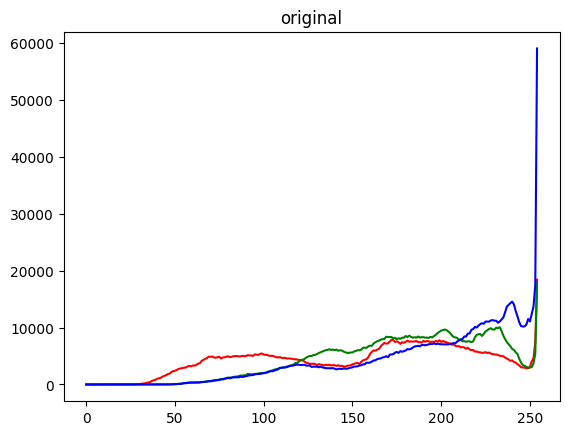

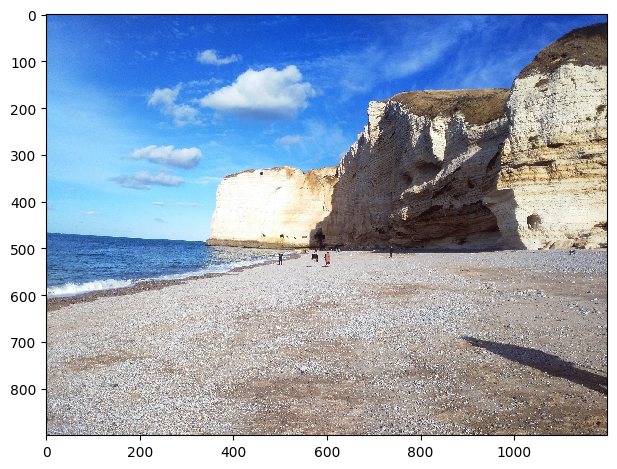

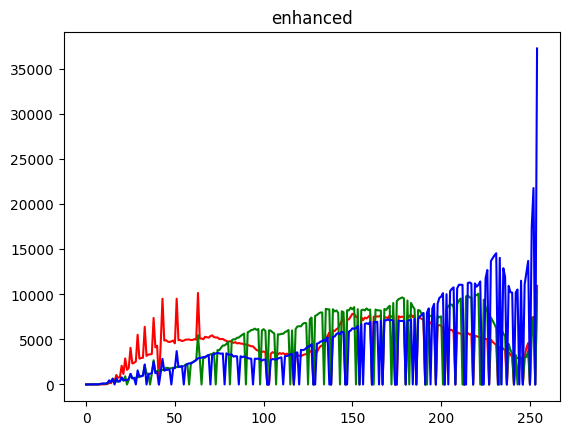

In [4]:
im = imread("etretat.jpg")
gamma = 1.3

show_histogram(im,"original")
im_enh = enchancement(im,gamma=gamma,autolevel=True,equalize=False,correct_lum=False,remove_noise=False)
imshow(im)
show_histogram(im_enh,"enhanced")

imsave("etretat_enhanced.jpg",im)